In [ ]:
#!pip install redshift_connector

In [15]:
# Import packages
import redshift_connector
import getpass
import awswrangler as wr
import matplotlib.pyplot as plot
import pandas as pd

## Data Distribution Exploratory Data Analysis
### Step 1: Enter the Redshift Database Credentials. 
These will be the same credentials used in the Airflow UI to connect to the redshift cluster: 

In [2]:
print('Enter the redshift endpoint URL')
redshift_endpoint = getpass.getpass()
print('Enter the redshift username')
redshift_username = getpass.getpass()
print('Enter the redshift password')
redshift_password = getpass.getpass()
print('Enter the redshift port number')
redshift_port = getpass.getpass()
print("Enter the db name")
redshift_dbname = getpass.getpass()

Enter the redshift endpoint URL
········
Enter the redshift username
········
Enter the redshift password
········
Enter the redshift port number
········
Enter the db name
········


### Step 2: Query the redshift database
This is a multi step process. 
1. Create a connection with the database using the credentials added during step 1
2. Use awswrangler to pass a SQL query through to redshift and save this in a variable
3. Close the connection

# Fact Table Distribution Analysis
In this next section we will look at how best to distribute the observation fact across the Redshift cluster nodes. I We will assess the distribution of the observations by: 
1. Counting the toal observations for Amphibia
2. Showing observation distribution per Amphibia taxon_id
3. Showing Amphibian observation data per month 
4. Showing Amphibian observation data per date


## 1. Count Total Amphibian Observations

In [166]:

#1. create a connection with redshift 
con = redshift_connector.connect(host=redshift_endpoint,
                                 database=redshift_dbname,
                                 user=redshift_username,
                                 password=redshift_password)

#2. run a SQL query
df = wr.redshift.read_sql_query(
        sql = """
        select 
            count(*) as records
        from 
            staging.observations_view""", 
        con=con)

#3. close the connection 
con.close()

# convert dataframe to a pandas dataframe 
val = df['records'].iloc[0].astype(str)
print(f'The filtered observation table contains {val} Amphibian observations')

The filtered observation table contains 560494 Amphibian observations


## 2. Observation distribution per Amphibia taxon_id

In [167]:
# Let's spreview the staging data for taxa. 
#1. create a connection with redshift 
con = redshift_connector.connect(host=redshift_endpoint,
                                 database=redshift_dbname,
                                 user=redshift_username,
                                 password=redshift_password)

#2. run a SQL query
taxon_df = wr.redshift.read_sql_query(
        sql = """
        select 
            count(*) as records, 
            taxon_id 
        from 
            staging.observations_view     
    where observed_on >= '2015-01-01'
        group by 
            taxon_id""", 
        con=con)

#3. close the connection 
con.close()

# convert dataframe to a pandas dataframe 
taxon_df = pd.DataFrame(taxon_df)

In [168]:
taxon_df.head(5)

,records,taxon_id
0,12266,65849
1,755,476245
2,18108,27186
3,1965,22631
4,12764,27805


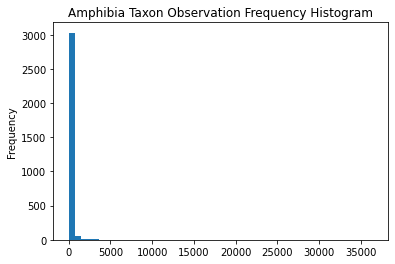

In [169]:
plot.hist(taxon_df['records'], bins=50)
plot.gca().set(title='Amphibia Taxon Observation Frequency Histogram', ylabel='Frequency');

## 3. Amphibian observation data distribution by month 

In [170]:
# Let's preview the staging data for taxa. 
#1. create a connection with redshift 
con = redshift_connector.connect(host=redshift_endpoint,
                                 database=redshift_dbname,
                                 user=redshift_username,
                                 password=redshift_password)

#2. run a SQL query
month_df = wr.redshift.read_sql_query(
"""
    select 
        count(*) as total_observations, 
        DATE_TRUNC('month', observed_on) as month 
    from 
        staging.observations_view
    where observed_on >= '2015-01-01'
    group by month""", 
        con=con)

#3. close the connection 
con.close()

# convert dataframe to a pandas dataframe 
month_df = pd.DataFrame(month_df)

In [133]:
month_df.head(5)

,records,month
0,3119,2016-05-01
1,14859,2020-09-01
2,1398,2015-09-01
3,1258,2015-10-01
4,6,1989-04-01


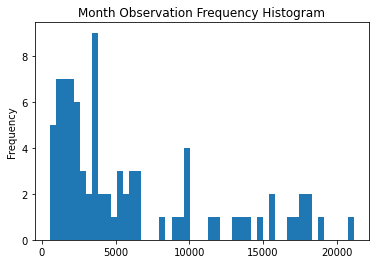

In [171]:
plot.hist(month_df['total_observations'], bins=50)
plot.gca().set(title='Month Observation Frequency Histogram', ylabel='Frequency');

## 4. Amphibian observation data distribution by date 

In [172]:
# Let's preview the staging data for taxa. 
#1. create a connection with redshift 
con = redshift_connector.connect(host=redshift_endpoint,
                                 database=redshift_dbname,
                                 user=redshift_username,
                                 password=redshift_password)

#2. run a SQL query
day_df = wr.redshift.read_sql_query(
"""
    select 
        count(*) as total_observations, 
        observed_on 
    from 
        staging.observations_view
    where observed_on >= '2015-01-01'
    group by observed_on""", 
        con=con)

#3. close the connection 
con.close()

# convert dataframe to a pandas dataframe 
day_df = pd.DataFrame(day_df)

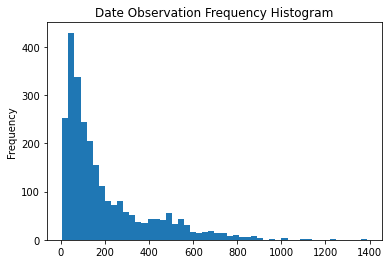

In [174]:
plot.hist(day_df['total_observations'], bins=50)
plot.gca().set(title='Date Observation Frequency Histogram', ylabel='Frequency');

# Conclusion 
The taxon distribution is heavily skewed by a few Amphibian species with many observations. 
This does not make the `taxon_id` a good candidate for the distribution key as the data would be unevenly distributed across cluster nodes. 

The observation distributions by month and date look better but aren't ideal either. However, as the iNaturalist platform increases in popularity, there will be more users contributing towards observations. With this in mind, I will distribute the `observations` table data across cluster nodes using the `observed_on` column.